In [0]:
from google.colab import drive

In [0]:
drive.mount('/content/gdrive')


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [0]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

In [0]:
#Define transforms for the training data and testing data
train_transforms = transforms.Compose([transforms.RandomRotation(30),
                                       transforms.Resize(256),
                                       transforms.RandomResizedCrop(224),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.225])])

test_transforms = transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])])
#pass transform here-in
train_data = datasets.ImageFolder('/content/drive/My Drive/Assignment 5 Dataset/train' , transform=train_transforms)
validate_data = datasets.ImageFolder('/content/drive/My Drive/Assignment 5 Dataset/validation', transform=train_transforms)
test_data = datasets.ImageFolder('/content/drive/My Drive/Assignment 5 Dataset/test', transform=test_transforms)
#data loaders
trainloader = torch.utils.data.DataLoader(train_data, batch_size=8, shuffle=True)
validateloader = torch.utils.data.DataLoader(validate_data, batch_size=8, shuffle=True)
testloader = torch.utils.data.DataLoader(test_data, batch_size=8, shuffle=True)

print("Classes: ")
class_names = train_data.classes
print(class_names)
print("length of train data", len(train_data))
print("length of Validate data", len(validate_data))

Classes: 
['infected', 'normal']
length of train data 12000
length of Validate data 1500


Part 1


Model 1: VGG16

In [0]:
vgg16 = models.vgg16(pretrained=True)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/checkpoints/vgg16-397923af.pth


In [0]:
num_features = vgg16.classifier[6].in_features
features = list(vgg16.classifier.children())[:-1] # Remove last layer
# print(features)

In [0]:
# freezing the covolution layers and keeping the FC layers
i = 0    
for layers in vgg16.children():
  # print(i)
  i += 1 
  # print(layers)
  if i < 2:
    for param in layers.parameters():
      # print(param)
      param.requires_grad = False 

In [0]:
# print(vgg16.classifier[6].in_features)
features[0] = nn.Linear(25088, 260,bias= True )
features[3] = nn.Linear(260,len(class_names))
# print(features)

In [0]:
vgg16.classifier = nn.Sequential(*features)
# print(vgg16)

In [0]:
Epochs = 10
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(vgg16.parameters(), lr=0.001, momentum=0.9)

Train Epoch: 0 [11992/12000 (100%)]	Loss: 0.693147: : 1500it [52:15,  2.09s/it]
Train Epoch: 1 [11992/12000 (100%)]	Loss: 0.693147: : 1500it [05:53,  4.24it/s]
Train Epoch: 2 [11992/12000 (100%)]	Loss: 0.693147: : 1500it [05:45,  4.34it/s]
Train Epoch: 3 [11992/12000 (100%)]	Loss: 0.693147: : 1500it [05:51,  4.27it/s]
Train Epoch: 4 [11992/12000 (100%)]	Loss: 0.606593: : 1500it [05:49,  4.29it/s]
Train Epoch: 5 [11992/12000 (100%)]	Loss: 0.766644: : 1500it [05:44,  4.35it/s]
Train Epoch: 6 [11992/12000 (100%)]	Loss: 0.484480: : 1500it [05:45,  4.34it/s]
Train Epoch: 7 [11992/12000 (100%)]	Loss: 0.432437: : 1500it [05:49,  4.29it/s]
Train Epoch: 8 [11992/12000 (100%)]	Loss: 0.368908: : 1500it [05:48,  4.30it/s]
Train Epoch: 9 [11992/12000 (100%)]	Loss: 0.635460: : 1500it [05:49,  4.29it/s]


Finished Training


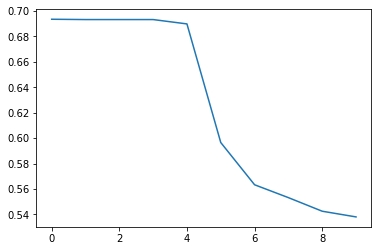

In [0]:
from tqdm import tqdm

#if you have gpu then you need to convert the network and data to cuda
#the easiest way is to first check for device and then convert network and data to device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
vgg16.to(device)
losses = []
vgg16.train()

for epoch in range(Epochs):  # loop over the dataset multiple times

    running_loss = 0.0
    pbar = tqdm(enumerate(trainloader))
    for i, data in pbar:
        # get the inputs
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()
        # In PyTorch, we need to set the gradients to zero before starting to do backpropragation 
        # because PyTorch accumulates the gradients on subsequent backward passes. 
        # This is convenient while training RNNs. 
        # So, the default action is to accumulate the gradients on every loss.backward() call

        # forward + backward + optimize
        outputs = vgg16(inputs)               #----> forward pass
        loss = criterion(outputs, labels)   #----> compute loss
        loss.backward()                     #----> backward pass
        optimizer.step()                    #----> weights update

        # print statistics
        running_loss += loss.item()
        
        pbar.set_description(
            'Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, i * len(inputs), len(trainloader.dataset),
                100. * i / len(trainloader),
                loss.data))
    losses.append(running_loss/1500)    
    torch.save(vgg16.state_dict(), 'vgg16_ft.pth')
plt.plot(losses)    
print('Finished Training')

training on validation

Train Epoch: 0 [748/1500 (99%)]	Loss: 0.368180: : 188it [07:07,  2.27s/it]
Train Epoch: 1 [748/1500 (99%)]	Loss: 0.354345: : 188it [00:40,  4.62it/s]
Train Epoch: 2 [748/1500 (99%)]	Loss: 0.685115: : 188it [00:40,  4.66it/s]
Train Epoch: 3 [748/1500 (99%)]	Loss: 0.188937: : 188it [00:40,  4.63it/s]
Train Epoch: 4 [748/1500 (99%)]	Loss: 0.623120: : 188it [00:40,  4.64it/s]
Train Epoch: 5 [748/1500 (99%)]	Loss: 0.431750: : 188it [00:40,  4.65it/s]
Train Epoch: 6 [748/1500 (99%)]	Loss: 0.697529: : 188it [00:40,  4.66it/s]
Train Epoch: 7 [748/1500 (99%)]	Loss: 0.693147: : 188it [00:40,  4.61it/s]
Train Epoch: 8 [748/1500 (99%)]	Loss: 0.476509: : 188it [00:40,  4.66it/s]
Train Epoch: 9 [748/1500 (99%)]	Loss: 0.693147: : 188it [00:40,  4.63it/s]


Finished Training


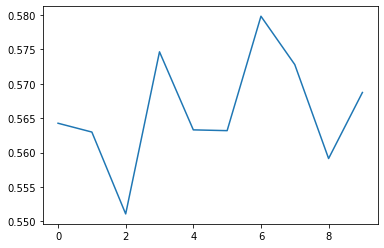

In [0]:
from tqdm import tqdm

#if you have gpu then you need to convert the network and data to cuda
#the easiest way is to first check for device and then convert network and data to device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
vgg16.to(device)
losses = []
vgg16.train()

for epoch in range(Epochs):  # loop over the dataset multiple times

    running_loss = 0.0
    pbar = tqdm(enumerate(validateloader))
    for i, data in pbar:
        # get the inputs
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()
        # In PyTorch, we need to set the gradients to zero before starting to do backpropragation 
        # because PyTorch accumulates the gradients on subsequent backward passes. 
        # This is convenient while training RNNs. 
        # So, the default action is to accumulate the gradients on every loss.backward() call

        # forward + backward + optimize
        outputs = vgg16(inputs)               #----> forward pass
        loss = criterion(outputs, labels)   #----> compute loss
        loss.backward()                     #----> backward pass
        optimizer.step()                    #----> weights update

        # print statistics
        running_loss += loss.item()
        
        pbar.set_description(
            'Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, i * len(inputs), len(validateloader.dataset),
                100. * i / len(validateloader),
                loss.data))
    losses.append(running_loss/187)    
    torch.save(vgg16.state_dict(), 'vgg16_ft.pth')
plt.plot(losses)    
print('Finished Training')

In [0]:
torch.save(vgg16.state_dict(), '/content/drive/My Drive/Colab Notebooks/vgg16_FC_Only.pth')

In [0]:
dataiter = iter(testloader)
images, labels = dataiter.next()

In [0]:
images, labels = images.to(device), labels.to(device) #-->convert test image to cuda (if available)
outputs = vgg16(images)                               #--> forward pass
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % class_names[predicted[j]]
                              for j in range(len(images))))
print('Ground Truth: ', ' '.join('%5s' % class_names[labels[j]]
                              for j in range(len(images))))

Predicted:  infected normal infected infected normal normal infected infected
Ground Truth:  normal normal infected normal normal normal infected infected


In [0]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = vgg16(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))
# print("Hahaha")

Accuracy of the network on the 10000 test images: 65 %


Model 2: Resnet18

In [0]:
resNet = models.resnet18(pretrained=True)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/checkpoints/resnet18-5c106cde.pth


In [0]:
i = 0    
for layers in resNet.children():
  i += 1 
  # print(layers)
  if i < 9:
    for param in layers.parameters():
      # print(param)
      param.requires_grad = False 

In [0]:
resNet.fc = nn.Sequential(
    nn.Linear(512,260,bias = True),
     nn.ReLU(inplace = True),
     nn.Dropout(p=0.5, inplace=False),
     nn.Linear(260,2,bias = True),
     nn.ReLU(inplace = True),
     nn.Dropout(p=0.5, inplace=False))

In [0]:
Epochs = 10
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(resNet.parameters(), lr=0.001, momentum=0.9)

In [0]:
from tqdm import tqdm

#if you have gpu then you need to convert the network and data to cuda
#the easiest way is to first check for device and then convert network and data to device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
resNet.to(device)
losses = []
resNet.train()

for epoch in range(Epochs):  # loop over the dataset multiple times

    running_loss = 0.0
    pbar = tqdm(enumerate(trainloader))
    for i, data in pbar:
        # get the inputs
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()
        # In PyTorch, we need to set the gradients to zero before starting to do backpropragation 
        # because PyTorch accumulates the gradients on subsequent backward passes. 
        # This is convenient while training RNNs. 
        # So, the default action is to accumulate the gradients on every loss.backward() call

        # forward + backward + optimize
        outputs = resNet(inputs)               #----> forward pass
        loss = criterion(outputs, labels)   #----> compute loss
        loss.backward()                     #----> backward pass
        optimizer.step()                    #----> weights update

        # print statistics
        running_loss += loss.item()
        
        pbar.set_description(
            'Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, i * len(inputs), len(trainloader.dataset),
                100. * i / len(trainloader),
                loss.data))
    losses.append(running_loss/1500)    
    torch.save(resNet.state_dict(), 'resNet_ft.pth')
plt.plot(losses)
print('Finished Training')

Train Epoch: 0 [11992/12000 (100%)]	Loss: 0.449374: : 1500it [1:49:08,  4.37s/it]
Train Epoch: 1 [11992/12000 (100%)]	Loss: 0.381608: : 1500it [06:28,  3.86it/s]
Train Epoch: 2 [11992/12000 (100%)]	Loss: 0.627510: : 1500it [06:11,  4.04it/s]
Train Epoch: 3 [11992/12000 (100%)]	Loss: 0.260721: : 1500it [06:03,  4.12it/s]
Train Epoch: 4 [11992/12000 (100%)]	Loss: 0.538448: : 1500it [05:54,  4.24it/s]
Train Epoch: 5 [11992/12000 (100%)]	Loss: 0.621047: : 1500it [05:49,  4.29it/s]
Train Epoch: 6 [3568/12000 (30%)]	Loss: 0.682061: : 447it [01:41,  4.44it/s]

training on validation data

In [0]:
from tqdm import tqdm

#if you have gpu then you need to convert the network and data to cuda
#the easiest way is to first check for device and then convert network and data to device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
resNet.to(device)
losses = []
resNet.train()

for epoch in range(Epochs):  # loop over the dataset multiple times

    running_loss = 0.0
    pbar = tqdm(enumerate(validateloader))
    for i, data in pbar:
        # get the inputs
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()
        # In PyTorch, we need to set the gradients to zero before starting to do backpropragation 
        # because PyTorch accumulates the gradients on subsequent backward passes. 
        # This is convenient while training RNNs. 
        # So, the default action is to accumulate the gradients on every loss.backward() call

        # forward + backward + optimize
        outputs = resNet(inputs)               #----> forward pass
        loss = criterion(outputs, labels)   #----> compute loss
        loss.backward()                     #----> backward pass
        optimizer.step()                    #----> weights update

        # print statistics
        running_loss += loss.item()
        
        pbar.set_description(
            'Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, i * len(inputs), len(validateloader.dataset),
                100. * i / len(validateloader),
                loss.data))
    losses.append(running_loss/187)    
    torch.save(resNet.state_dict(), 'resNet_ft.pth')
plt.plot(losses)    
print('Finished Training')


0it [00:00, ?it/s]
Train Epoch: 0 [0/1500 (0%)]	Loss: 2.420501: : 0it [00:04, ?it/s]
Train Epoch: 0 [0/1500 (0%)]	Loss: 2.420501: : 1it [00:04,  4.20s/it]
Train Epoch: 0 [8/1500 (1%)]	Loss: 0.970768: : 1it [00:08,  4.20s/it]
Train Epoch: 0 [8/1500 (1%)]	Loss: 0.970768: : 2it [00:08,  4.16s/it]
Train Epoch: 0 [16/1500 (1%)]	Loss: 3.912593: : 2it [00:12,  4.16s/it]
Train Epoch: 0 [16/1500 (1%)]	Loss: 3.912593: : 3it [00:12,  4.14s/it]
Train Epoch: 0 [24/1500 (2%)]	Loss: 2.170721: : 3it [00:16,  4.14s/it]
Train Epoch: 0 [24/1500 (2%)]	Loss: 2.170721: : 4it [00:16,  4.27s/it]
Train Epoch: 0 [32/1500 (2%)]	Loss: 1.516475: : 4it [00:21,  4.27s/it]
Train Epoch: 0 [32/1500 (2%)]	Loss: 1.516475: : 5it [00:21,  4.39s/it]
Train Epoch: 0 [40/1500 (3%)]	Loss: 1.904842: : 5it [00:25,  4.39s/it]
Train Epoch: 0 [40/1500 (3%)]	Loss: 1.904842: : 6it [00:25,  4.32s/it]
Train Epoch: 0 [48/1500 (3%)]	Loss: 1.346164: : 6it [00:30,  4.32s/it]
Train Epoch: 0 [48/1500 (3%)]	Loss: 1.346164: : 7it [00:30,  4.33

KeyboardInterrupt: ignored

In [0]:
torch.save(resNet.state_dict(), '/content/drive/My Drive/Colab Notebooks/res18_FC_Only.pth')

In [0]:
dataiter = iter(testloader)
images, labels = dataiter.next()

In [0]:
images, labels = images.to(device), labels.to(device) #-->convert test image to cuda (if available)
outputs = resNet(images)                               #--> forward pass
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % class_names[predicted[j]]
                              for j in range(len(images))))
print('Ground Truth: ', ' '.join('%5s' % class_names[labels[j]]
                              for j in range(len(images))))

In [0]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = resNet(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))
# print("Hahaha")

Part 2

Modle 1: Vgg16 with one conv layer freezed 

In [0]:
vgg16 = models.vgg16(pretrained=True)

In [0]:
num_features = vgg16.classifier[6].in_features
features = list(vgg16.classifier.children())[:-1] # Remove last layer
print(features)

In [0]:
i = 0
for param in vgg16.parameters():
  if i == 12 or i == 13: # Because I want to freeze layer of param 12 and 13
    param.requires_grad = False
    # print(param)
  i += 1
  # print(param)  

In [0]:
# print(vgg16.classifier[6].in_features)
features[0] = nn.Linear(25088, 260,bias= True )
features[3] = nn.Linear(260,len(class_names))
# print(features)

In [0]:
vgg16.classifier = nn.Sequential(*features)

In [0]:
Epochs = 10
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(vgg16.parameters(), lr=0.001, momentum=0.9)

In [0]:
from tqdm import tqdm

#if you have gpu then you need to convert the network and data to cuda
#the easiest way is to first check for device and then convert network and data to device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
vgg16.to(device)
losses = []
vgg16.train()

for epoch in range(Epochs):  # loop over the dataset multiple times

    running_loss = 0.0
    pbar = tqdm(enumerate(trainloader))
    for i, data in pbar:
        # get the inputs
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()
        # In PyTorch, we need to set the gradients to zero before starting to do backpropragation 
        # because PyTorch accumulates the gradients on subsequent backward passes. 
        # This is convenient while training RNNs. 
        # So, the default action is to accumulate the gradients on every loss.backward() call

        # forward + backward + optimize
        outputs = resNet(inputs)               #----> forward pass
        loss = criterion(outputs, labels)   #----> compute loss
        loss.backward()                     #----> backward pass
        optimizer.step()                    #----> weights update

        # print statistics
        running_loss += loss.item()
        
        pbar.set_description(
            'Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, i * len(inputs), len(trainloader.dataset),
                100. * i / len(trainloader),
                loss.data))
    losses.append(running_loss/1500)    
    torch.save(resNet.state_dict(), 'vgg16_ft.pth')
plt.plot(losses)
print('Finished Training')

training on validation data

In [0]:
from tqdm import tqdm

#if you have gpu then you need to convert the network and data to cuda
#the easiest way is to first check for device and then convert network and data to device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
vgg16.to(device)
losses = []
vgg16.train()

for epoch in range(Epochs):  # loop over the dataset multiple times

    running_loss = 0.0
    pbar = tqdm(enumerate(validateloader))
    for i, data in pbar:
        # get the inputs
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()
        # In PyTorch, we need to set the gradients to zero before starting to do backpropragation 
        # because PyTorch accumulates the gradients on subsequent backward passes. 
        # This is convenient while training RNNs. 
        # So, the default action is to accumulate the gradients on every loss.backward() call

        # forward + backward + optimize
        outputs = resNet(inputs)               #----> forward pass
        loss = criterion(outputs, labels)   #----> compute loss
        loss.backward()                     #----> backward pass
        optimizer.step()                    #----> weights update

        # print statistics
        running_loss += loss.item()
        
        pbar.set_description(
            'Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, i * len(inputs), len(validateloader.dataset),
                100. * i / len(validateloader),
                loss.data))
    losses.append(running_loss/187)    
    torch.save(resNet.state_dict(), 'vgg16_ft.pth')
plt.plot(losses)    
print('Finished Training')

In [0]:
torch.save(vgg16.state_dict(), '/content/drive/My Drive/Colab Notebooks/vgg16_Conv1_FC.pth')

In [0]:
dataiter = iter(testloader)
images, labels = dataiter.next()

In [0]:
images, labels = images.to(device), labels.to(device) #-->convert test image to cuda (if available)
outputs = vgg16(images)                               #--> forward pass
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % class_names[predicted[j]]
                              for j in range(len(images))))
print('Ground Truth: ', ' '.join('%5s' % class_names[labels[j]]
                              for j in range(len(images))))

In [0]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = vgg16(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))
# print("Hahaha")

Vgg16 with more than one freezed layer conv

In [0]:
li = [5,6,7,8,9,10,11]
i = 0
for param in vgg16.parameters():
  if i in li: # Because I want to freeze layer of param 12 and 13
    param.requires_grad = False
    # print(param)
  i += 1
  # print(param)  

In [0]:
vgg16.features[12] = nn.Conv2d(256, 256, 3, 1, 1)

In [0]:
# vgg16.children 
Epochs = 10
print("hahahahah")

In [0]:
from tqdm import tqdm

#if you have gpu then you need to convert the network and data to cuda
#the easiest way is to first check for device and then convert network and data to device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
vgg16.to(device)
losses = []
vgg16.train()

for epoch in range(Epochs):  # loop over the dataset multiple times

    running_loss = 0.0
    pbar = tqdm(enumerate(trainloader))
    for i, data in pbar:
        # get the inputs
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()
        # In PyTorch, we need to set the gradients to zero before starting to do backpropragation 
        # because PyTorch accumulates the gradients on subsequent backward passes. 
        # This is convenient while training RNNs. 
        # So, the default action is to accumulate the gradients on every loss.backward() call

        # forward + backward + optimize
        outputs = vgg16(inputs)               #----> forward pass
        loss = criterion(outputs, labels)   #----> compute loss
        loss.backward()                     #----> backward pass
        optimizer.step()                    #----> weights update

        # print statistics
        running_loss += loss.item()
        
        pbar.set_description(
            'Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, i * len(inputs), len(trainloader.dataset),
                100. * i / len(trainloader),
                loss.data))
    losses.append(running_loss/1500)    
    torch.save(vgg16.state_dict(), 'vgg16_ft.pth')
plt.plot(losses)
print('Finished Training')

Training on Validated dataset

In [0]:
from tqdm import tqdm

#if you have gpu then you need to convert the network and data to cuda
#the easiest way is to first check for device and then convert network and data to device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
vgg16.to(device)
losses = []
vgg16.train()

for epoch in range(Epochs):  # loop over the dataset multiple times

    running_loss = 0.0
    pbar = tqdm(enumerate(validateloader))
    for i, data in pbar:
        # get the inputs
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()
        # In PyTorch, we need to set the gradients to zero before starting to do backpropragation 
        # because PyTorch accumulates the gradients on subsequent backward passes. 
        # This is convenient while training RNNs. 
        # So, the default action is to accumulate the gradients on every loss.backward() call

        # forward + backward + optimize
        outputs = vgg16(inputs)               #----> forward pass
        loss = criterion(outputs, labels)   #----> compute loss
        loss.backward()                     #----> backward pass
        optimizer.step()                    #----> weights update

        # print statistics
        running_loss += loss.item()
        
        pbar.set_description(
            'Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, i * len(inputs), len(validateloader.dataset),
                100. * i / len(validateloader),
                loss.data))
    losses.append(running_loss/1500)    
    torch.save(vgg16.state_dict(), 'vgg16_ft.pth')
plt.plot(losses)
print('Finished Training')

In [0]:
torch.save(vgg16.state_dict(), '/content/drive/My Drive/Colab Notebooks/vgg16_Conv2_FC.pth')

In [0]:
dataiter = iter(testloader)
images, labels = dataiter.next()

In [0]:
images, labels = images.to(device), labels.to(device) #-->convert test image to cuda (if available)
outputs = vgg16(images)                               #--> forward pass
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % class_names[predicted[j]]
                              for j in range(len(images))))
print('Ground Truth: ', ' '.join('%5s' % class_names[labels[j]]
                              for j in range(len(images))))

In [0]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = vgg16(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))
# print("Hahaha")

Model 2: Resnet18

Renet with one freezed conv layer

In [0]:
resNet = models.resnet18(pretrained=True)

In [0]:

i = 0    
for layers in resNet.children():
   
  # print(layers)
  if i == 5:
    # print(layers)
    for param in layers.parameters():
      param.requires_grad = False
  i += 1    


In [0]:
resNet.fc = nn.Sequential(
    nn.Linear(512,260,bias = True),
     nn.ReLU(inplace = True),
     nn.Dropout(p=0.5, inplace=False),
     nn.Linear(260,2,bias = True),
     nn.ReLU(inplace = True),
     nn.Dropout(p=0.5, inplace=False))

In [0]:
Epochs = 10
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(resNet.parameters(), lr=0.001, momentum=0.9)

Train Epoch: 0 [11992/12000 (100%)]	Loss: 0.233256: : 1500it [06:36,  3.78it/s]
Train Epoch: 1 [11992/12000 (100%)]	Loss: 0.406418: : 1500it [06:28,  3.86it/s]
Train Epoch: 2 [11992/12000 (100%)]	Loss: 0.540176: : 1500it [06:29,  3.85it/s]
Train Epoch: 3 [11992/12000 (100%)]	Loss: 0.635055: : 1500it [06:27,  3.88it/s]
Train Epoch: 4 [11992/12000 (100%)]	Loss: 0.321242: : 1500it [06:28,  3.86it/s]
Train Epoch: 5 [11992/12000 (100%)]	Loss: 0.554010: : 1500it [06:26,  3.88it/s]
Train Epoch: 6 [11992/12000 (100%)]	Loss: 1.057959: : 1500it [06:26,  3.88it/s]
Train Epoch: 7 [11992/12000 (100%)]	Loss: 0.635193: : 1500it [06:38,  3.76it/s]
Train Epoch: 8 [11992/12000 (100%)]	Loss: 0.198527: : 1500it [06:30,  3.84it/s]
Train Epoch: 9 [11992/12000 (100%)]	Loss: 0.367242: : 1500it [06:28,  3.86it/s]


Finished Training


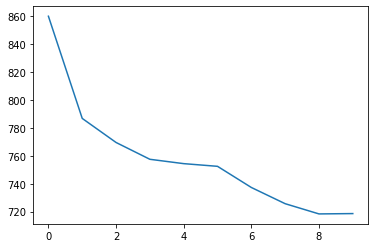

In [0]:
from tqdm import tqdm

#if you have gpu then you need to convert the network and data to cuda
#the easiest way is to first check for device and then convert network and data to device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
resNet.to(device)
losses = []
resNet.train()

for epoch in range(Epochs):  # loop over the dataset multiple times

    running_loss = 0.0
    pbar = tqdm(enumerate(trainloader))
    for i, data in pbar:
        # get the inputs
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()
        # In PyTorch, we need to set the gradients to zero before starting to do backpropragation 
        # because PyTorch accumulates the gradients on subsequent backward passes. 
        # This is convenient while training RNNs. 
        # So, the default action is to accumulate the gradients on every loss.backward() call

        # forward + backward + optimize
        outputs = resNet(inputs)               #----> forward pass
        loss = criterion(outputs, labels)   #----> compute loss
        loss.backward()                     #----> backward pass
        optimizer.step()                    #----> weights update

        # print statistics
        running_loss += loss.item()
        
        pbar.set_description(
            'Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, i * len(inputs), len(trainloader.dataset),
                100. * i / len(trainloader),
                loss.data))
    losses.append(running_loss)    
    torch.save(resNet.state_dict(), 'resNet_ft.pth')
plt.plot(losses)
print('Finished Training')

traing on Validation data

Train Epoch: 0 [748/1500 (99%)]	Loss: 1.063620: : 188it [00:48,  3.84it/s]
Train Epoch: 1 [748/1500 (99%)]	Loss: 0.280623: : 188it [00:44,  4.26it/s]
Train Epoch: 2 [748/1500 (99%)]	Loss: 0.693147: : 188it [00:43,  4.28it/s]
Train Epoch: 3 [748/1500 (99%)]	Loss: 0.360450: : 188it [00:44,  4.21it/s]
Train Epoch: 4 [748/1500 (99%)]	Loss: 0.368166: : 188it [00:43,  4.27it/s]
Train Epoch: 5 [748/1500 (99%)]	Loss: 0.420203: : 188it [00:44,  4.27it/s]
Train Epoch: 6 [748/1500 (99%)]	Loss: 1.073973: : 188it [00:44,  4.25it/s]
Train Epoch: 7 [748/1500 (99%)]	Loss: 0.354312: : 188it [00:44,  4.20it/s]
Train Epoch: 8 [748/1500 (99%)]	Loss: 0.313080: : 188it [00:44,  4.25it/s]
Train Epoch: 9 [748/1500 (99%)]	Loss: 0.803531: : 188it [00:44,  4.24it/s]


Finished Training


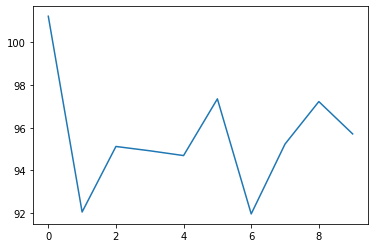

In [0]:
from tqdm import tqdm

#if you have gpu then you need to convert the network and data to cuda
#the easiest way is to first check for device and then convert network and data to device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
resNet.to(device)
losses = []
resNet.train()

for epoch in range(Epochs):  # loop over the dataset multiple times

    running_loss = 0.0
    pbar = tqdm(enumerate(validateloader))
    for i, data in pbar:
        # get the inputs
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()
        # In PyTorch, we need to set the gradients to zero before starting to do backpropragation 
        # because PyTorch accumulates the gradients on subsequent backward passes. 
        # This is convenient while training RNNs. 
        # So, the default action is to accumulate the gradients on every loss.backward() call

        # forward + backward + optimize
        outputs = resNet(inputs)               #----> forward pass
        loss = criterion(outputs, labels)   #----> compute loss
        loss.backward()                     #----> backward pass
        optimizer.step()                    #----> weights update

        # print statistics
        running_loss += loss.item()
        
        pbar.set_description(
            'Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, i * len(inputs), len(validateloader.dataset),
                100. * i / len(validateloader),
                loss.data))
    losses.append(running_loss)    
    torch.save(resNet.state_dict(), 'resNet_ft.pth')
plt.plot(losses)
print('Finished Training')

In [0]:
torch.save(resNet.state_dict(), '/content/drive/My Drive/Colab Notebooks/resNet18_conv1_FC.pth')

In [0]:
dataiter = iter(testloader)
images, labels = dataiter.next()

In [0]:
images, labels = images.to(device), labels.to(device) #-->convert test image to cuda (if available)
outputs = resNet(images)                               #--> forward pass
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % class_names[predicted[j]]
                              for j in range(len(images))))
print('Ground Truth: ', ' '.join('%5s' % class_names[labels[j]]
                              for j in range(len(images))))

Predicted:  normal normal normal infected normal infected normal infected
Ground Truth:  normal normal normal infected normal normal normal infected


In [0]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = resNet(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))
# print("Hahaha")

Accuracy of the network on the 10000 test images: 68 %


Resnet More than one conv layer freezed

In [0]:
li = [5,6]
i = 0
for layer in resNet.children():
  if i in li:
    # print(layer[0])
    for param in layer:
      param.requires_grad = False
  i += 1  

In [0]:
Epochs = 10
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(resNet.parameters(), lr=0.001, momentum=0.9)

Train Epoch: 0 [11992/12000 (100%)]	Loss: 0.550605: : 1500it [06:35,  3.79it/s]
Train Epoch: 1 [11992/12000 (100%)]	Loss: 0.738781: : 1500it [06:25,  3.89it/s]
Train Epoch: 2 [11992/12000 (100%)]	Loss: 0.606965: : 1500it [06:26,  3.88it/s]
Train Epoch: 3 [11992/12000 (100%)]	Loss: 0.369965: : 1500it [06:27,  3.87it/s]
Train Epoch: 4 [11992/12000 (100%)]	Loss: 0.606530: : 1500it [06:30,  3.84it/s]
Train Epoch: 5 [11992/12000 (100%)]	Loss: 0.455918: : 1500it [06:28,  3.86it/s]
Train Epoch: 6 [11992/12000 (100%)]	Loss: 0.347679: : 1500it [06:26,  3.89it/s]
Train Epoch: 7 [11992/12000 (100%)]	Loss: 0.560260: : 1500it [06:26,  3.88it/s]
Train Epoch: 8 [11992/12000 (100%)]	Loss: 0.279404: : 1500it [06:28,  3.86it/s]
Train Epoch: 9 [11992/12000 (100%)]	Loss: 0.348393: : 1500it [06:28,  3.86it/s]


Finished Training


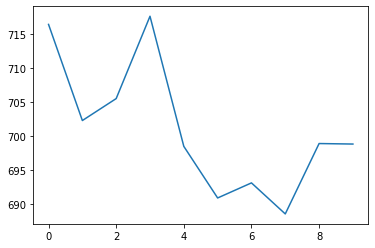

In [0]:
from tqdm import tqdm

#if you have gpu then you need to convert the network and data to cuda
#the easiest way is to first check for device and then convert network and data to device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
resNet.to(device)
losses = []
resNet.train()

for epoch in range(Epochs):  # loop over the dataset multiple times

    running_loss = 0.0
    pbar = tqdm(enumerate(trainloader))
    for i, data in pbar:
        # get the inputs
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()
        # In PyTorch, we need to set the gradients to zero before starting to do backpropragation 
        # because PyTorch accumulates the gradients on subsequent backward passes. 
        # This is convenient while training RNNs. 
        # So, the default action is to accumulate the gradients on every loss.backward() call

        # forward + backward + optimize
        outputs = resNet(inputs)               #----> forward pass
        loss = criterion(outputs, labels)   #----> compute loss
        loss.backward()                     #----> backward pass
        optimizer.step()                    #----> weights update

        # print statistics
        running_loss += loss.item()
        
        pbar.set_description(
            'Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, i * len(inputs), len(trainloader.dataset),
                100. * i / len(trainloader),
                loss.data))
    losses.append(running_loss)    
    torch.save(resNet.state_dict(), 'resNet_ft.pth')
plt.plot(losses)
print('Finished Training')

Training on Validation data

Train Epoch: 0 [748/1500 (99%)]	Loss: 0.693147: : 188it [01:01,  3.05it/s]
Train Epoch: 1 [748/1500 (99%)]	Loss: 0.693147: : 188it [00:57,  3.25it/s]
Train Epoch: 2 [748/1500 (99%)]	Loss: 0.693147: : 188it [00:57,  3.27it/s]
Train Epoch: 3 [748/1500 (99%)]	Loss: 0.693147: : 188it [00:57,  3.28it/s]
Train Epoch: 4 [748/1500 (99%)]	Loss: 0.693147: : 188it [00:57,  3.28it/s]
Train Epoch: 5 [748/1500 (99%)]	Loss: 0.693147: : 188it [00:57,  3.27it/s]
Train Epoch: 6 [748/1500 (99%)]	Loss: 0.693147: : 188it [00:57,  3.25it/s]
Train Epoch: 7 [748/1500 (99%)]	Loss: 0.693147: : 188it [00:57,  3.27it/s]
Train Epoch: 8 [748/1500 (99%)]	Loss: 0.693147: : 188it [00:57,  3.26it/s]
Train Epoch: 9 [748/1500 (99%)]	Loss: 0.693147: : 188it [00:57,  3.26it/s]


Finished Training


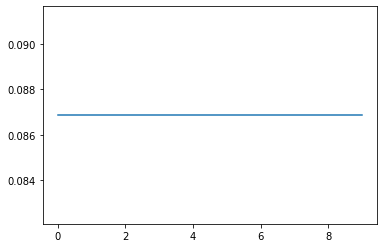

In [0]:
from tqdm import tqdm

#if you have gpu then you need to convert the network and data to cuda
#the easiest way is to first check for device and then convert network and data to device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
resNet.to(device)
losses = []
resNet.train()

for epoch in range(Epochs):  # loop over the dataset multiple times

    running_loss = 0.0
    pbar = tqdm(enumerate(validateloader))
    for i, data in pbar:
        # get the inputs
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()
        # In PyTorch, we need to set the gradients to zero before starting to do backpropragation 
        # because PyTorch accumulates the gradients on subsequent backward passes. 
        # This is convenient while training RNNs. 
        # So, the default action is to accumulate the gradients on every loss.backward() call

        # forward + backward + optimize
        outputs = vgg16(inputs)               #----> forward pass
        loss = criterion(outputs, labels)   #----> compute loss
        loss.backward()                     #----> backward pass
        optimizer.step()                    #----> weights update

        # print statistics
        running_loss += loss.item()
        
        pbar.set_description(
            'Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, i * len(inputs), len(validateloader.dataset),
                100. * i / len(validateloader),
                loss.data))
    losses.append(running_loss/1500)    
    torch.save(resNet.state_dict(), 'resNet.pth')
plt.plot(losses)
print('Finished Training')

In [0]:
torch.save(resNet.state_dict(), '/content/drive/My Drive/Colab Notebooks/resNet18_conv2_FC.pth')

In [0]:
dataiter = iter(testloader)
images, labels = dataiter.next()

In [0]:
images, labels = images.to(device), labels.to(device) #-->convert test image to cuda (if available)
outputs = resNet(images)                               #--> forward pass
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % class_names[predicted[j]]
                              for j in range(len(images))))
print('Ground Truth: ', ' '.join('%5s' % class_names[labels[j]]
                              for j in range(len(images))))

Predicted:  infected infected normal infected infected infected infected infected
Ground Truth:  normal infected normal normal infected infected infected infected


In [0]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = resNet(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))
# print("Hahaha")

Accuracy of the network on the 10000 test images: 68 %


End
